# Case Study 1

This notebook is self-contained and confirmed to run using a Julia 1.7.1 kernel. It will generate Figures 1 and 3 from the manuscript.  It uses the packages Plots.jl, LaTeXStrings.jl, and Printf.jl, as well as a PGFPlotsX backend. If they are not already installed, they can be installed by running the first cell.

In [ ]:
using Pkg
Pkg.add("Plots")
Pkg.add("LaTeXStrings")
Pkg.add("Printf")
Pkg.add("PGFPlotsX")

The cell below loads all packages necessary to execute subsequent cells; it also sets the plotting backend for Plots.jl to pgfplotsx()

In [17]:
using Plots
using LaTeXStrings
using Printf
pgfplotsx(); #set plotting backend to PGFplotsX

We will consider the simple, homogeneous reaction outlined in the manuscript:

$$A \longrightarrow B$$

It is an elementary step and proceeds through a transition state.  It occurs in the liquid phase, and we will consider it in a few different solvent environments.  The properties of the solvent--i.e., the excess free energies of species in that solvent--will be modelled using activity coefficients. The cell below creates functions that describe activity coefficients, rate constants, reversibilities, and reaction rate as they are defined in the manuscript.

Note again that in this Case Study, we treat the product, species B, as the solvent, and we simulate the impact of a changing solvation environment as the reaction proceeds from 0% conversion (pure A and a thermodynamically ideal environment) to 100% conversion (pure B and an infinite dilution environment for species A).

In [18]:
gammaA(XS,  A12A)  = exp.(XS.^2*A12A)
gammaTS(XS, A12TS) = exp.(XS.^2*A12TS)
gammaB(XS,  A12B)  = exp.(XS.^2*A12B)
k(XS, A12A, A12TS) = k10*gammaA(XS, A12A)./gammaTS(XS, A12TS)
z(XA, XB, XS, A12A, A12B) = 1/K10*gammaB(XS, A12B)./gammaA(XS, A12A).*XB./XA
rate(XA, XB, XS, A12A, A12B, A12TS) = k10*gammaA(XS, A12A)./gammaTS(XS, A12TS).*XA.*(1 .- z(XA, XB, XS, A12A, A12B));

The cell below will simulate the magnitude of the rate constant in thermodynamically "real" media ($k^\prime$) normalized by the rate constant in thermodyanmically ideal media ($k^\circ$) as a function of fractional conversion. This is intended to demonstrate that, for reactions in liquid media, one should generally expect that the observed rate "constant" may vary both with the identity of the solvent as well as with composition of the reacting mixture within that solvent.

The figure below is Figure 1 in the manuscript.

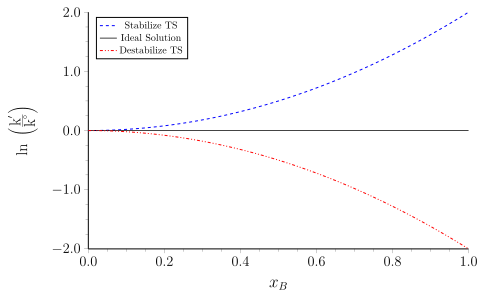

In [12]:
k10  = 1.0
K10  = 1.0
XA0  = 1.0
CONV = 0.0:0.01:1.0
XA   = XA0*(1 .- CONV)
XB   = 1 .- XA
XS   = XB
XTS = copy(XA)

plt1 = plot(
    xlim = (0.0, 1.0),
    xticks = 0.0:0.2:1.0,
    xminorticks = 4,
    ylim = (-2.0, 2.0),
    yticks = (-2.0:1.0:2.0, [@sprintf("%1.1f", x) for x in -2.0:1.0:2.0]),
    yminorticks = 4,
    tick_direction = :out, 
    grid = :off, 
    guidefontsize = 16, 
    tickfontsize = 14,
    xlabel = L"{x}_B", 
    ylabel = L"\textrm{ln} \ \left(\frac{\textrm{k}^\prime}{\textrm{k}^\circ}\right)",  
    fontfamily = "Times Roman",
    legendfontsize = 10,
    legend = :topleft,
    legendfonthalign = :left
)

plt1 = plot!(plt1, XB, log.(k(XS, 0., -2.)), ls = :dash,         lc = :blue,  lw = 1.00, label = "Stabilize TS")
plt1 = plot!(plt1, XB, log.(k(XS, 0., 0.)),  ls = :solid,        lc = :black, lw = 0.75, label = "Ideal Solution")
plt1 = plot!(plt1, XB, log.(k(XS, 0., 2.)),  ls = :dashdotdot,   lc = :red,   lw = 1.00, label = "Destabilize TS")

display(plt1)
savefig(plt1, "CS1a1.pdf")

The cell below computes reaction rate as a function of reactant mole fraction in two different hypothetical solvent scenarios--one where a transition state is stabilized by water solvation and another where the transition state is destabilized by hexadecane solvation.  Both systems are considered at concentrations ranging from 0.0 to 2.0 molar, which is representative of many experimental studies of liquid phase reactions.  However, this concentration range corresponds to very different dilution environments in hexadecane and water.  In the case of water, which has a very small molecular weight, all rates are computed at or near infinite dilution, so we observe that activity coefficients and thus rate constants are roughly composition independent.  In contrast, hexadecane has a high molecular weight, so this reactant concentration traverses outside of the infinite dilution limit, and one thus observes composition-dependent rate constants and falsified reaction orders. 

The cell below will produce Figure 3a from the manuscript.  It will also regress apparent reaction orders from simulated rate data; these are also reported in the manuscript.

2×2 Matrix{Float64}:
 5.65076   0.652954
 0.950825  1.29446

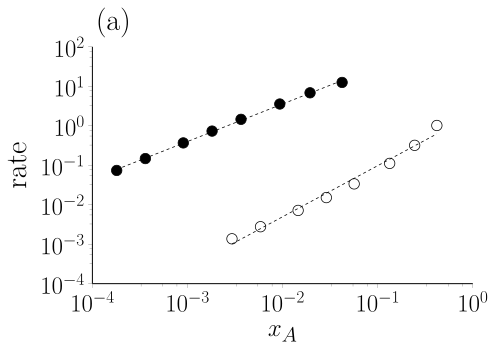

In [13]:
rhoA = 808   #g/L
rhoW = 1000  #g/L
rhoH = 770   #g/mL
MWA  = 74.1  #g/mol
MWW  = 18.0  #g/mol
MWH  = 226.5 #g/mol
VA   = MWA/rhoA #L/mol
VW   = MWW/rhoW #L/mol
VH   = MWH/rhoH #L/mol 

V    = 100 #L
CA0  = [0.01, 0.02, 0.05, 0.1, 0.2, 0.5, 1.0, 2.0]   #mol/L
NA0  = CA0*V #mol
VA0  = NA0*VA #L
VW0  = V .- VA0 #L
NW0  = VW0/VW  #mol
CW0  = NW0/V #mol/L
VH0  = V .- VA0 #L
NH0  = VH0/VH
CH0  = NH0/V
NTW  = NA0 + NW0
NTH  = NA0 + NH0

XAW  = NA0./(NA0 + NW0)
XAH  = NA0./(NA0 + NH0)
XBW  = zeros(length(XAW),)
XBH  = zeros(length(XAH),)
XW   = 1 .- XAW
XH   = 1 .- XAH

X1        = ones(length(XAW), 2)
X1[:,2]   = log.(XAW)
X2        = ones(length(XAH), 2)
X2[:,2]   = log.(XAH)
Y1        = log.(rate(XAW, XBW, XW, 0., 0., -2.).*NTW/V)
Y2        = log.(rate(XAH, XBH, XH, 0., 0., 2.).*NTH/V)

A1   = (X1'*X1)\X1'*Y1
A2   = (X2'*X2)\X2'*Y2

plt2 = plot(
    xlim = (1e-4, 1e0),
    #xticks = -9.0:3.0:0.0,
    xscale = :log10,
    xminorticks = 4,
    ylim = (1e-4, 1e2),
    #yticks = -8.0:4.0:4.0,
    yscale = :log10,
    yminorticks = 4,
    tick_direction = :out, 
    grid = :off, 
    guidefontsize = 30, 
    tickfontsize = 24,
    xlabel = L"{x}_{A}", 
    ylabel = L"\textrm{rate}",  
    fontfamily = "Times Roman",
    legendfontsize = 14,
    legend = nothing,
    title = "(a)",
    titlelocation = :left,
    titlefontsize = 30
)

plt2 = scatter!(plt2, exp.(X1[:,2]), exp.(Y1), label = "Water", m = :circle, ms = 7, color = :black)
plt2 = scatter!(plt2, exp.(X2[:,2]), exp.(Y2), label = "Hexadecane", m = :circle, ms = 7, color = :white)
plt2 = plot!(plt2, exp.(X1[:,2]), exp.(X1*A1), ls = :dash, lc = :black, lw = 0.75, label = nothing)
plt2 = plot!(plt2, exp.(X2[:,2]), exp.(X2*A2), ls = :dash, lc = :black, lw = 0.75, label = nothing)

display([A1 A2])
display(plt2)
savefig(plt2, "CS1a2.pdf")

The cell below is the truncated version of the one above; it considers only low-concentration data to illustrate that true reaction orders are measured at low concentrations where systems remain at the infinite dilution limit, and activity coefficients are composition-independent.

2×2 Matrix{Float64}:
 1.97611   -1.74372
 0.997236   1.04366

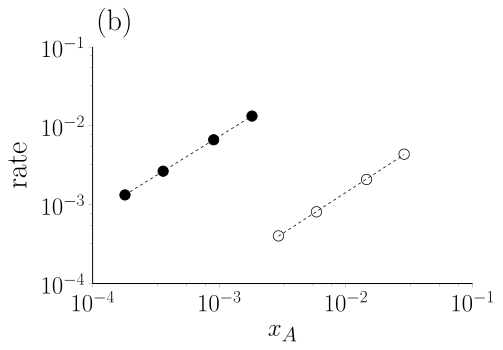

In [14]:
rhoA = 808   #g/L
rhoW = 1000  #g/L
rhoH = 770   #g/mL
MWA  = 74.1  #g/mol
MWW  = 18.0  #g/mol
MWH  = 226.5 #g/mol
VA   = MWA/rhoA #L/mol
VW   = MWW/rhoW #L/mol
VH   = MWH/rhoH #L/mol 

V    = 100 #L
CA0  = [0.01, 0.02, 0.05, 0.1]   #mol/L
NA0  = CA0*V #mol
VA0  = NA0*VA #L
VW0  = V .- VA0 #L
NW0  = VW0/VW  #mol
CW0  = NW0/V #mol/L
VH0  = V .- VA0 #L
NH0  = VH0/VH
CH0  = NH0/V
NTW  = NA0 + NW0
NTH  = NA0 + NH0

XAW  = NA0./(NA0 + NW0)
XAH  = NA0./(NA0 + NH0)
XBW  = zeros(length(XAW),)
XBH  = zeros(length(XAH),)
XW   = 1 .- XAW
XH   = 1 .- XAH

X1        = ones(length(XAW), 2)
X1[:,2]   = log.(XAW)
X2        = ones(length(XAH), 2)
X2[:,2]   = log.(XAH)
Y1        = log.(rate(XAW, XBW, XW, 0., 0., -2.))
Y2        = log.(rate(XAH, XBH, XH, 0., 0., 2.))

A1   = (X1'*X1)\X1'*Y1
A2   = (X2'*X2)\X2'*Y2

plt3 = plot(
    xlim = (1e-4, 1e-1),
    #xticks = -9.0:1.0:-3.0,
    xscale = :log10,
    xminorticks = 4,
    ylim = (1e-4, 1e-1),
    #yticks = -8.0:1.0:-4.0,
    yscale = :log10,
    yminorticks = 4,
    tick_direction = :out, 
    grid = :off, 
    guidefontsize = 30, 
    tickfontsize = 24,
    xlabel = L"{x}_{A}", 
    ylabel = L"\textrm{rate}",  
    fontfamily = "Times Roman",
    legendfontsize = 14,
    legend = nothing,
    title = "(b)",
    titlelocation = :left,
    titlefontsize = 30
)

plt3 = scatter!(plt3, exp.(X1[:,2]), exp.(Y1), label = "Water", m = :circle, ms = 7, color = :black)
plt3 = scatter!(plt3, exp.(X2[:,2]), exp.(Y2), label = "Hexadecane", m = :circle, ms = 7, color = :white)
plt3 = plot!(plt3, exp.(X1[:,2]), exp.(X1*A1), ls = :dash, lc = :black, lw = 0.75, label = nothing)
plt3 = plot!(plt3, exp.(X2[:,2]), exp.(X2*A2), ls = :dash, lc = :black, lw = 0.75, label = nothing)
display([A1 A2])
display(plt3)
savefig(plt3, "CS1a3.pdf")

The cell below is a complement to the one above; it considers only high-concentration data to illustrate that falsified reaction orders are measured at high concentrations where systems exceed the infinite dilution limit, and activity coefficients are composition-dependent.

2×2 Matrix{Float64}:
 5.35955   1.34322
 0.882189  1.68622

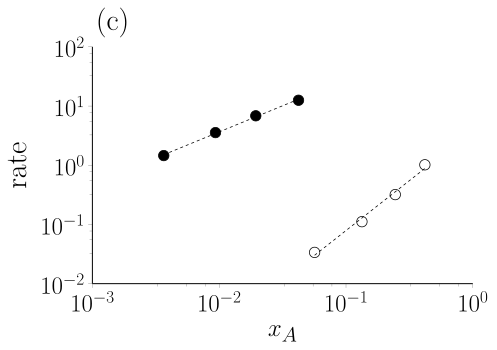

In [15]:
rhoA = 808   #g/L
rhoW = 1000  #g/L
rhoH = 770   #g/mL
MWA  = 74.1  #g/mol
MWW  = 18.0  #g/mol
MWH  = 226.5 #g/mol
VA   = MWA/rhoA #L/mol
VW   = MWW/rhoW #L/mol
VH   = MWH/rhoH #L/mol 

V    = 100 #L
CA0  = [0.2, 0.5, 1.0, 2.0]   #mol/L
NA0  = CA0*V #mol
VA0  = NA0*VA #L
VW0  = V .- VA0 #L
NW0  = VW0/VW  #mol
CW0  = NW0/V #mol/L
VH0  = V .- VA0 #L
NH0  = VH0/VH
CH0  = NH0/V
NTW  = NA0 + NW0
NTH  = NA0 + NH0

XAW  = NA0./(NA0 + NW0)
XAH  = NA0./(NA0 + NH0)
XBW  = zeros(length(XAW),)
XBH  = zeros(length(XAH),)
XW   = 1 .- XAW
XH   = 1 .- XAH

X1        = ones(length(XAW), 2)
X1[:,2]   = log.(XAW)
X2        = ones(length(XAH), 2)
X2[:,2]   = log.(XAH)
Y1        = log.(rate(XAW, XBW, XW, 0., 0., -2.).*NTW/V)
Y2        = log.(rate(XAH, XBH, XH, 0., 0., 2.).*NTH/V)

A1   = (X1'*X1)\X1'*Y1
A2   = (X2'*X2)\X2'*Y2

plt4 = plot(
    xlim = (1e-3, 1e0),
    #xticks = -6.0:1.0:0.0,
    xscale = :log10,
    xminorticks = 4,
    ylim = (1e-2, 1e2),
    #yticks = -4.0:2.0:4.0,
    yscale = :log10,
    yminorticks = 4,
    tick_direction = :out, 
    grid = :off, 
    guidefontsize = 30, 
    tickfontsize = 24,
    xlabel = L"{x}_{A}", 
    ylabel = L"\textrm{rate}",  
    fontfamily = "Times Roman",
    legendfontsize = 14,
    legend = nothing,
    title = "(c)",
    titlelocation = :left,
    titlefontsize = 30
)

plt4 = scatter!(plt4, exp.(X1[:,2]), exp.(Y1), label = "Water", m = :circle, ms = 7, color = :black)
plt4 = scatter!(plt4, exp.(X2[:,2]), exp.(Y2), label = "Hexadecane", m = :circle, ms = 7, color = :white)
plt4 = plot!(plt4, exp.(X1[:,2]), exp.(X1*A1), ls = :dash, lc = :black, lw = 0.75, label = nothing)
plt4 = plot!(plt4, exp.(X2[:,2]), exp.(X2*A2), ls = :dash, lc = :black, lw = 0.75, label = nothing)

display([A1 A2])
display(plt4)
savefig(plt4, "CS1a4.pdf")

The cell below converts reactant concentrations reported into the manuscript into reactant mole fractions in water (XAW) and hexadecane (XAH)

In [38]:
rhoA = 808   #g/L
rhoW = 1000  #g/L
rhoH = 770   #g/mL
MWA  = 74.1  #g/mol
MWW  = 18.0  #g/mol
MWH  = 226.5 #g/mol
VA   = MWA/rhoA #L/mol
VW   = MWW/rhoW #L/mol
VH   = MWH/rhoH #L/mol 

V    = 100 #L
CA0  = [0.01, 0.02, 0.05, 0.1, 0.2, 0.5, 1.0, 2.0]   #mol/L   #mol/L
NA0  = CA0*V #mol
VA0  = NA0*VA #L
VW0  = V .- VA0 #L
NW0  = VW0/VW  #mol
CW0  = NW0/V #mol/L
VH0  = V .- VA0 #L
NH0  = VH0/VH
CH0  = NH0/V
NTW  = NA0 + NW0
NTH  = NA0 + NH0

XAW  = NA0./(NA0 + NW0)
XAH  = NA0./(NA0 + NH0)

for (a, b, c) in zip(CA0, XAW, XAH)
    @printf("At a concentration of %0.2fM, the mole fraction of A is %0.2E in water and %0.2E in hexadecane. \n", a, b, c)
end

At a concentration of 0.01M, the mole fraction of A is 1.80E-04 in water and 2.94E-03 in hexadecane. 
At a concentration of 0.02M, the mole fraction of A is 3.61E-04 in water and 5.86E-03 in hexadecane. 
At a concentration of 0.05M, the mole fraction of A is 9.03E-04 in water and 1.46E-02 in hexadecane. 
At a concentration of 0.10M, the mole fraction of A is 1.81E-03 in water and 2.88E-02 in hexadecane. 
At a concentration of 0.20M, the mole fraction of A is 3.65E-03 in water and 5.65E-02 in hexadecane. 
At a concentration of 0.50M, the mole fraction of A is 9.34E-03 in water and 1.34E-01 in hexadecane. 
At a concentration of 1.00M, the mole fraction of A is 1.94E-02 in water and 2.45E-01 in hexadecane. 
At a concentration of 2.00M, the mole fraction of A is 4.22E-02 in water and 4.19E-01 in hexadecane. 
